In [549]:
import wandb
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [550]:
api = wandb.Api()

In [551]:
# runs = api.runs("pari/skdwda-pari",
#     {"$or": [
#        {"config.algs": "dqo"},
#        #{"config.wandb_tags":"run_all,final1"},
#        #{"config.wandb_tags":"run_all,final2"},
#        {"config.wandb_tags":"run_all,final2-fixedBestVal"}
#     ]
#     })

runs = api.runs("pari/MyCEB",
    {"$and": [
       {"config.algs": "mscn"},
       {"config.train_test_split_kind":"template"},
       {"config.query_dir":"queries/imdb-unique-plans"},
       {"config.no_regex_templates":0},
       {"config.embedding_fn":"none"},
       {"config.feat_separate_alias":0},
       {"$or": [ 
           {"config.subplan_level_outputs":0},
           {"config.subplan_level_outputs":None},
       ]},
       {"$or": [ 
           {"config.training_opt":""},
           {"config.training_opt":"none"},
           {"config.training_opt":None},
       ]},
       {"config.weight_decay":0},
       {"$or": [
#             {"$and": [
#                 {"tags":"v13"},
#                 {"config.loss_func_name":"flowloss"},
#             ]},
#             {"$and": [
#                 {"tags":"v14"},
#                 {"config.loss_func_name":"flowloss"},
#             ]},
           {"tags":"v15"},
           {"tags":"v16"},
           {"tags":"v17"},
           {"tags":"v16-job1"},
           {"tags":"v16-job2"},
           {"tags":"v16-job3"},
       ]}
    
    ]
    })

print(f"Found {len(runs)} runs")

Found 627 runs


In [552]:
SAVE_DIR = "/Users/pari/Desktop/"
#/Users/pari/Desktop

In [553]:
import time
start = time.time()
summary_list, config_list, name_list = [], [], []
#TAGS = ["baselines", "baseline", "best_model_0.2", "best_model"]
dfs = []

for run in runs:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)

took:  8.446616888046265


In [554]:
df = pd.concat(dfs)

In [555]:
#print(df.keys())
print(len(df))

520


In [556]:
df.head(5)

,Tags,name,lr,pwd,algs,port,seed,user,opt_lr,skip7a,...,Final-Relative-TotalPPCost-val-1a,Final-Relative-TotalPPCost-test-C2-7a,Final-Relative-TotalPPCost-test-C2-11a,Final-Relative-TotalPPCost-test-11a,PostgresPlanCost-C-Relative-val,QError-val,QError-job,PostgresPlanCost-C-Relative-job,QError-test,PostgresPlanCost-C-Relative-test
0,[v17],elated-wave-10326,0.0001,password,mscn,5431,123,ceb,0.005,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,[v17],cool-cloud-10314,0.0001,password,mscn,5431,123,ceb,0.005,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,[v17],trim-pond-10313,0.0001,password,mscn,5431,123,ceb,0.005,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,[v17],fragrant-shadow-10312,0.0001,password,mscn,5431,123,ceb,0.005,0,...,8.175,1.809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,[v17],chocolate-snowball-10311,0.0001,password,mscn,5431,123,ceb,0.005,0,...,1.731,NaN,4.482,3.303,NaN,NaN,NaN,NaN,NaN,NaN


In [557]:
df = df[df.epoch >= 2]
df = df[df.max_discrete_featurizing_buckets.isin([1,10])]
df = df[df.hidden_layer_size.isin([128, 256])]
print(len(df))

515


In [558]:
print(set(df["table_features"]))
print(set(df["join_features"]))
print(set(df["set_column_feature"]))
print(set(df["max_discrete_featurizing_buckets"]))
#print(set(df["mask_unseen_subplans"]))
print(set(df["onehot_dropout"]))
#print(set(df["onehot_mask_truep"]))
print(set(df["loss_func_name"]))
print(set(df["hidden_layer_size"]))

{1}
{'onehot-stats', 'onehot'}
{'onehot-stats', 'onehot'}
{1, 10}
{0, 2}
{'mse', 'flowloss', 'qloss'}
{128}


In [570]:
def get_row_featurization(row):
    ret = ""
    if row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["loss_func_name"] == "mse" \
        and row["ynormalization"] == "log" \
        and row["load_query_together"] == 0 \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 0:
        if row["sample_bitmap"] == 0 and row["max_discrete_featurizing_buckets"] == 10 and \
            row["max_like_featurizing_buckets"] == 10:
            ret = "Default"
        elif row["sample_bitmap"] == 1:
            ret = "Default + Sample Bitmap-" \
            + str(row["max_discrete_featurizing_buckets"]) \
            + str(row["max_like_featurizing_buckets"])
        else:
            ret = "Default (unknown)"
    
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["loss_func_name"] == "qloss" \
        and row["ynormalization"] == "log" \
        and row["load_query_together"] == 0 \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 0 \
        and row["sample_bitmap"] == 1 \
        and row["heuristic_features"] == 0:
        ret = "MSCN-original"       
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 1 \
        and row["max_like_featurizing_buckets"] == 1 \
        and row["loss_func_name"] == "mse" \
        and row["load_query_together"] == 0 \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 0:
        ret = "Default (onehot, no-buckets)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "mse" \
        and row["load_query_together"] == 0 \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 2 \
        and row["heuristic_features"] == 1:
        ret = "Default-dropout-" + str(row["onehot_mask_truep"])
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "flowloss" \
        and row["weight_decay"] == 0 \
        and row["normalize_flow_loss"] == 1 \
        and row["flow_features"] == 1:
        ret = "FlowLoss (onehot)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot-stats" \
        and row["join_features"] == "onehot-stats" \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "flowloss" \
        and row["weight_decay"] == 0 \
        and row["normalize_flow_loss"] == 1 \
        and row["flow_features"] == 1:
        ret = "FlowLoss (onehot-stats)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot-stats" \
        and row["join_features"] == "onehot-stats" \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "flowloss" \
        and row["weight_decay"] == 0 \
        and row["normalize_flow_loss"] == 1 \
        and row["flow_features"] == 1 \
        and row["onehot_dropout"] == 2:
        ret = "FlowLoss (onehot-stats-dropout)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "flowloss" \
        and row["weight_decay"] == 0 \
        and row["normalize_flow_loss"] == 0 \
        and row["flow_features"] == 1:
        ret = "FlowLoss2 (onehot)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "mse+ranknet" \
        and row["load_query_together"] == 1:
        ret = "MSE+ranknet"
    
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot-stats" \
        and row["join_features"] == "onehot-stats" \
        and row["loss_func_name"] == "mse" \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 2:
        if row["sample_bitmap"] == 1:
            ret = "Onehot-Stats-Dropout-Bitmap-" + \
            str(row["max_discrete_featurizing_buckets"]) + "-" + \
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        else:
            ret = "Onehot-Stats-Dropout-" + str(row["max_discrete_featurizing_buckets"]) + "-" +\
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot" \
        and row["join_features"] == "onehot" \
        and row["loss_func_name"] == "mse" \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 2:
        if row["sample_bitmap"] == 1:
            ret = "Onehot-Dropout-Bitmap-" + \
            str(row["max_discrete_featurizing_buckets"]) + "-" + \
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        else:
            ret = "Onehot-Dropout-" + str(row["max_discrete_featurizing_buckets"]) + "-" +\
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot-stats" \
        and row["join_features"] == "onehot-stats" \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "mse" \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] > 0 \
        and row["max_epochs"] == 20:
        ret = "Onehot-Stats-dropout" + str(row["onehot_dropout"])
    elif row["table_features"] == 0 \
        and row["set_column_feature"] == "stats" \
        and row["join_features"] == "stats" \
        and row["loss_func_name"] == "mse" \
        and row["weight_decay"] == 0:
        ret = "OnlyStats"
    else:
        ret = "unknown"
    
    if row["feat_separate_like_ests"] == 1:
        ret += "-sepLike"
    
    if row["feat_true_base_cards"] == 1:
        ret += "-trueBase"
        
    if row["early_stopping"] in [1,2]:
        ret += "-ES" + str(int(row["early_stopping"]))
        
#     if row["feat_onlyseen_maxy"] == 1:
#         ret += "-maxY"  
#     ret += "-ep" + str(row["max_epochs"])
    
    return ret

In [571]:
df["Featurization"] = df.apply(lambda x: get_row_featurization(x), axis=1)

In [572]:
print(set(df["Featurization"]))

{'Onehot-Dropout-Bitmap-10-1-20-0.8-ES2', 'Default-dropout-0.8-ES2', 'Default-dropout-0.9-ES2', 'Default', 'Default + Sample Bitmap-11', 'Onehot-Stats-Dropout-10-10-10-0.8', 'FlowLoss (onehot)', 'Default-dropout-0.8', 'Default-dropout-0.9', 'FlowLoss (onehot-stats)', 'Default-dropout-0.7', 'Onehot-Dropout-Bitmap-1-1-20-0.8-ES2', 'MSCN-original'}


In [573]:
df.groupby(["Featurization"]).count()

,Tags,name,lr,pwd,algs,port,seed,user,opt_lr,skip7a,...,Final-Relative-TotalPPCost-val-1a,Final-Relative-TotalPPCost-test-C2-7a,Final-Relative-TotalPPCost-test-C2-11a,Final-Relative-TotalPPCost-test-11a,PostgresPlanCost-C-Relative-val,QError-val,QError-job,PostgresPlanCost-C-Relative-job,QError-test,PostgresPlanCost-C-Relative-test
Featurization,,,,,,,,,,,,,,,,,,,,,
Default,176,176,176,176,176,176,176,176,176,176,...,87,74,103,121,18,18,0,0,18,18
Default + Sample Bitmap-11,30,30,30,30,30,30,30,30,30,30,...,12,14,24,24,0,0,0,0,0,0
Default-dropout-0.7,51,51,51,51,51,51,51,51,51,51,...,0,20,21,21,15,15,15,15,15,15
Default-dropout-0.8,19,19,19,19,19,19,19,19,19,19,...,13,0,0,19,19,19,0,0,19,19
Default-dropout-0.8-ES2,71,71,71,71,71,71,71,71,71,71,...,39,34,45,45,71,71,0,0,0,0
Default-dropout-0.9,15,15,15,15,15,15,15,15,15,15,...,2,0,0,2,15,15,15,15,15,15
Default-dropout-0.9-ES2,16,16,16,16,16,16,16,16,16,16,...,10,5,13,13,16,16,0,0,0,0
FlowLoss (onehot),1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,1,1,1
FlowLoss (onehot-stats),30,30,30,30,30,30,30,30,30,30,...,14,14,14,14,0,0,0,0,0,0


In [574]:
print(set(df["Featurization"]))

{'Onehot-Dropout-Bitmap-10-1-20-0.8-ES2', 'Default-dropout-0.8-ES2', 'Default-dropout-0.9-ES2', 'Default', 'Default + Sample Bitmap-11', 'Onehot-Stats-Dropout-10-10-10-0.8', 'FlowLoss (onehot)', 'Default-dropout-0.8', 'Default-dropout-0.9', 'FlowLoss (onehot-stats)', 'Default-dropout-0.7', 'Onehot-Dropout-Bitmap-1-1-20-0.8-ES2', 'MSCN-original'}


In [575]:
print(df.keys())

Index(['Tags', 'name', 'lr', 'pwd', 'algs', 'port', 'seed', 'user', 'opt_lr',
       'skip7a',
       ...
       'Final-Relative-TotalPPCost-test-C2-7a',
       'Final-Relative-TotalPPCost-test-C2-11a',
       'Final-Relative-TotalPPCost-test-11a',
       'PostgresPlanCost-C-Relative-val', 'QError-val', 'QError-job',
       'PostgresPlanCost-C-Relative-job', 'QError-test',
       'PostgresPlanCost-C-Relative-test', 'Featurization'],
      dtype='object', length=253)


In [576]:
# pdf = df[df.Featurization.isin(['Default',
#                                 #'Default-maxY-ep20',
#                                 #'Default-maxY-ep10',
#                                 'Default-dropout-0.8-ES2-ep20',
#                                 #'Default-dropout-0.9-ES2-ep20',
#                                 'Default + Sample Bitmap-11-ep10',
#                                 #'Default + Sample Bitmap-1010-ep10',
#                                 "FlowLoss (onehot-stats)-ep10",
#                                 #'OnlyStats-ep10',
#                                 #'Default-dropout-0.8-ep20',
#                                 #'Default-dropout-0.7-ep20'
#                                ])]
# ci = None
# estimator = np.max

In [579]:
pdf = df[df.Featurization.isin(['Default',
                                #'Default-dropout-0.8-ES2-ep20',
                                'Default-dropout-0.8-ES2',
                                #'Default + Sample Bitmap-11',
                                #'Onehot-Dropout-Bitmap-1-1-20-0.8-ES2',
                                'MSCN-original',
                                "FlowLoss (onehot-stats)",
                               ])]
ci = None
estimator = np.mean
#SEEDS = [7, 13, 14, 17, 19, 20]
#pdf = pdf[pdf.diff_templates_seed.isin(SEEDS)]
#pdf

In [580]:

# plt.style.use("seaborn-white")
# fig, axs = plt.subplots(figsize=(30,21), nrows=3, ncols=1)
# ax = axs[0]
# sns.barplot(x="diff_templates_seed", y="Final-Relative-TotalPPCost-train", hue="Featurization", data=pdf, 
#            ax=ax, ci=ci)
# ax.set_ylabel("Relative Total PostgreSQL Cost", fontsize=20)
# ax.set_xlabel("Seeds", fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# ax = axs[1]
# # sns.barplot(x="diff_templates_seed", y="Final-PostgresPlanCost-C-train-mean", hue="Featurization", data=pdf, 
# #            ax=ax, ci=ci)
# # ax.set_yscale("log")
# sns.barplot(x="diff_templates_seed", y="Final-Relative-TotalPPCost-train-C2", hue="Featurization", data=pdf, 
#            ax=ax, ci=ci)
# ax.set_ylabel("PostgreSQL Cost (mean)", fontsize=20)
# ax.set_xlabel("Seeds", fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# ax = axs[2]
# sns.barplot(x="diff_templates_seed", y="Final-QError-train-mean", hue="Featurization", data=pdf, 
#            ax=ax, ci=ci)
# ax.set_yscale("log")
# ax.set_ylabel("QError (mean)", fontsize=20)
# ax.set_xlabel("Seeds", fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# FN = os.path.join(SAVE_DIR, "AllSeedsSummary-train.pdf")
# plt.savefig(FN)

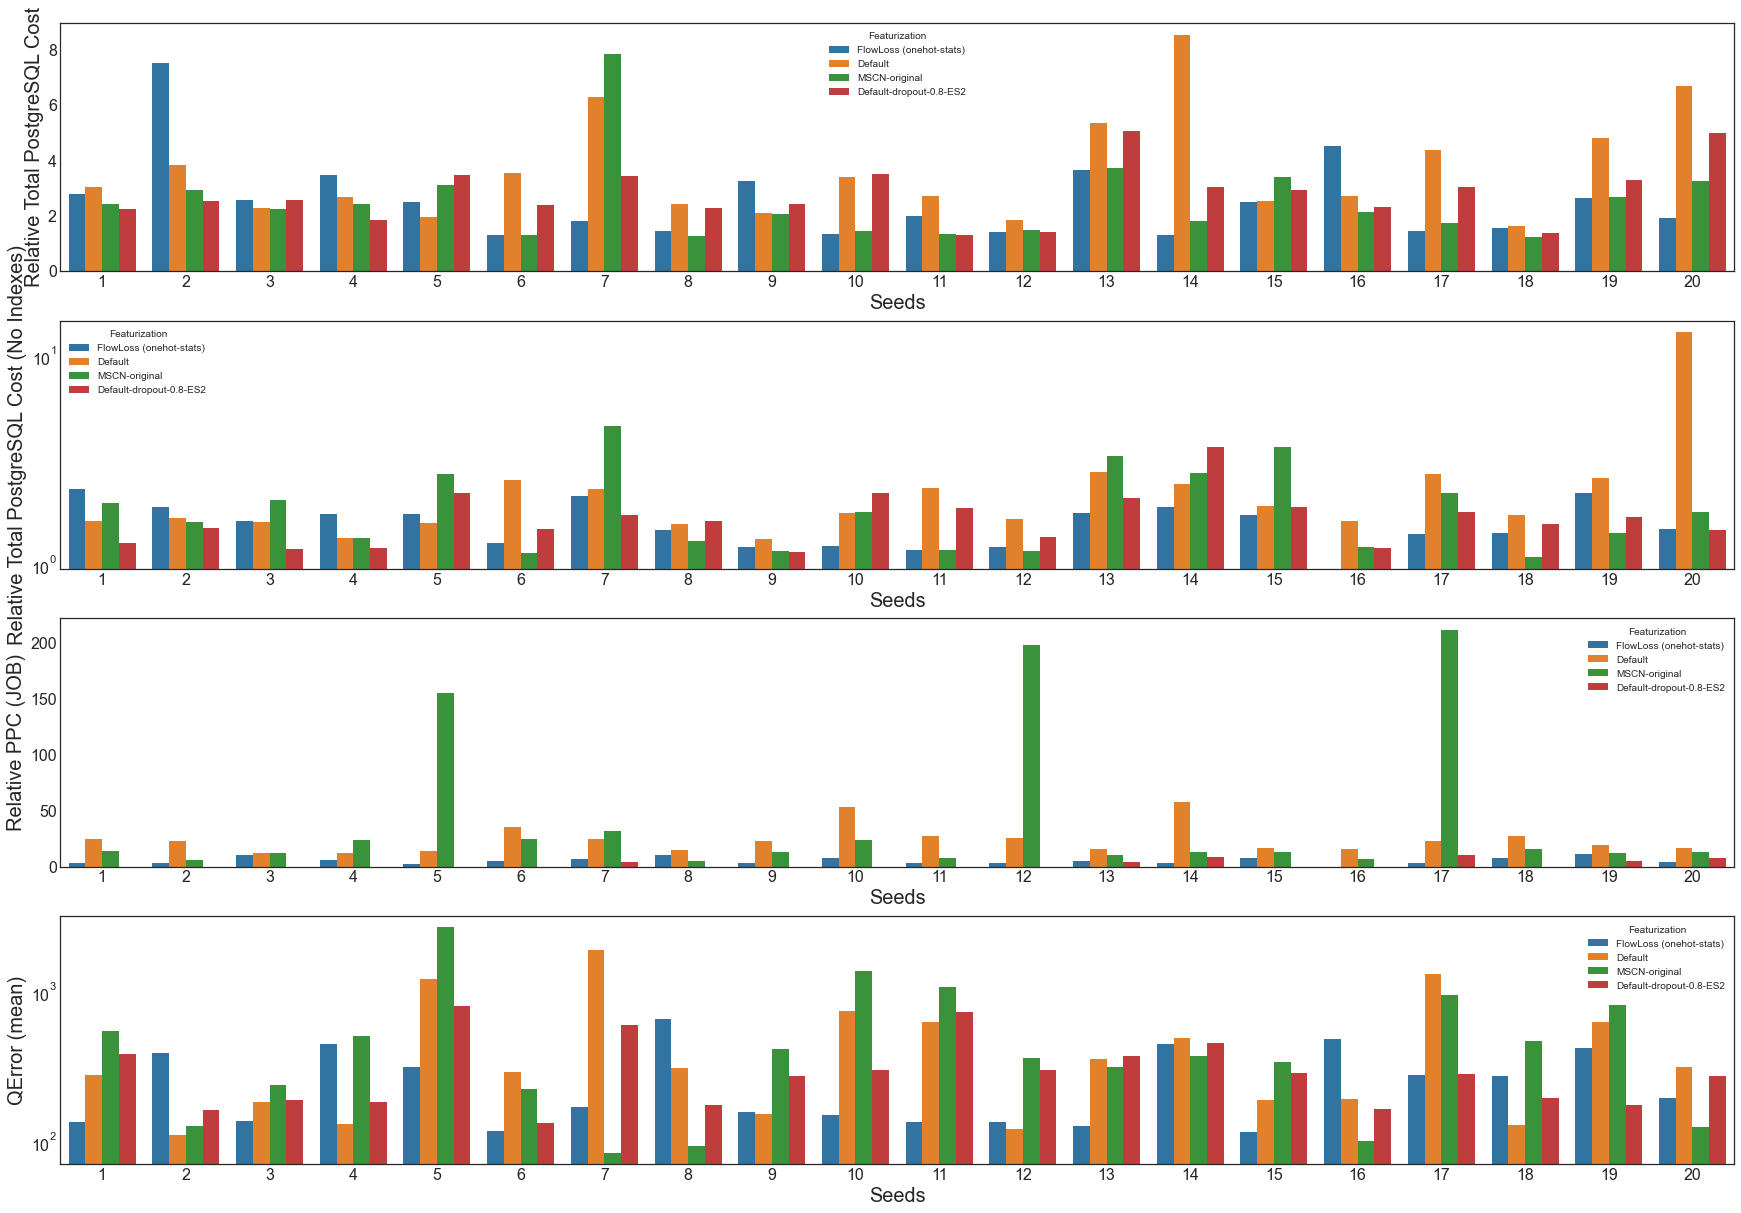

In [582]:
plt.style.use("seaborn-white")
fig, axs = plt.subplots(figsize=(30,21), nrows=4, ncols=1)
ax = axs[0]
sns.barplot(x="diff_templates_seed", y="Final-Relative-TotalPPCost-test", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator)
ax.set_ylabel("Relative Total PostgreSQL Cost", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

# ax = axs[1]
# sns.barplot(x="diff_templates_seed", y="Final-PostgresPlanCost-C-test-mean", hue="Featurization", data=pdf, 
#            ax=ax, ci=ci)
# ax.set_yscale("log")
# ax.set_ylabel("PostgreSQL Cost (mean)", fontsize=20)
# ax.set_xlabel("Seeds", fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

ax = axs[1]
sns.barplot(x="diff_templates_seed", y="Final-Relative-TotalPPCost-test-C2", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator)
ax.set_yscale("log")
ax.set_ylabel("Relative Total PostgreSQL Cost (No Indexes)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

ax = axs[2]
sns.barplot(x="diff_templates_seed", y="Final-Relative-TotalPPCost-job", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator)
ax.set_ylabel("Relative PPC (JOB)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

ax = axs[3]
sns.barplot(x="diff_templates_seed", y="Final-QError-test-mean", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator)
ax.set_yscale("log")
ax.set_ylabel("QError (mean)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

FN = os.path.join(SAVE_DIR, "AllSeedsSummary-test.pdf")
plt.savefig(FN)

# Only comparing JOB performance

In [596]:
pdf = df[df.Featurization.isin(['Default',
                                #'Default-dropout-0.8-ES2-ep20',
                                'Default-dropout-0.8-ES2',
                                'Onehot-Dropout-Bitmap-1-1-20-0.8-ES2',
                                'Onehot-Dropout-Bitmap-10-1-20-0.8-ES2',
                                #'MSCN-original',
                                "FlowLoss (onehot-stats)",
                               ])]
ci = None
estimator = np.mean
#SEEDS = [7, 13, 14, 17, 19, 20]
#pdf = pdf[pdf.diff_templates_seed.isin(SEEDS)]
#pdf

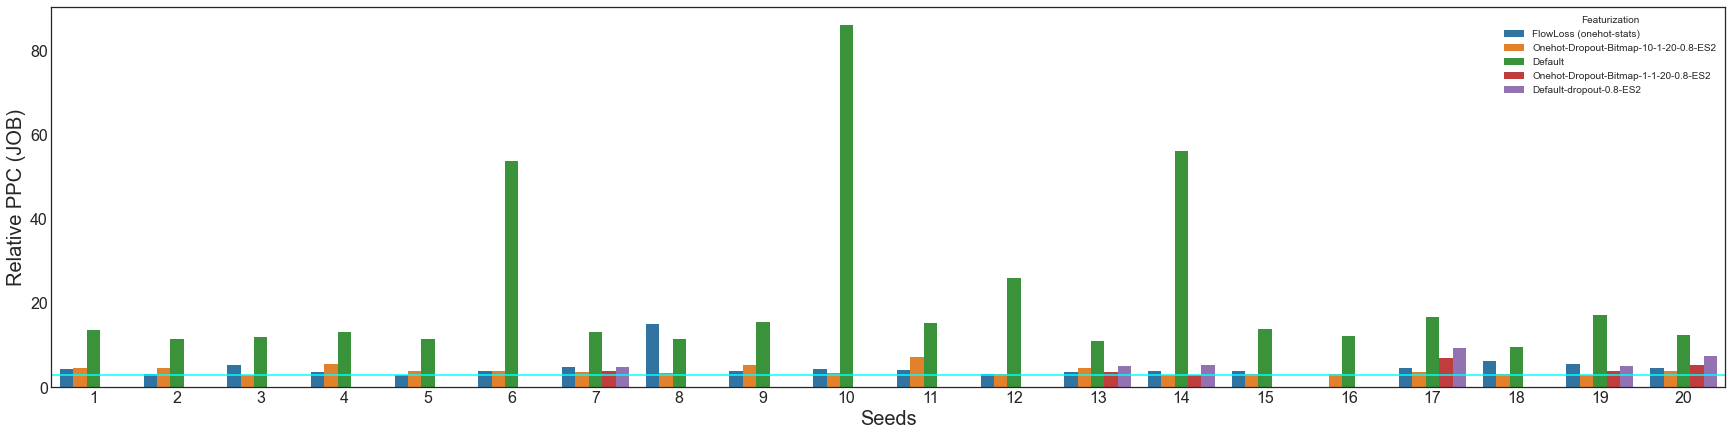

In [597]:
plt.style.use("seaborn-white")
fig, ax = plt.subplots(figsize=(30,7), nrows=1, ncols=1)

sns.barplot(x="diff_templates_seed", y="Final-Relative-TotalPPCost-job-all_job", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator)
#ax.hline(y=3.0, color="cyan")
plt.axhline(y=3.0, color="cyan")
ax.set_ylabel("Relative PPC (JOB)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

In [547]:
pdf = df[df.Featurization.isin([#'Default',
                                #'Default-dropout-0.8-ES2',
                                'Default + Sample Bitmap-11',
                                'Onehot-Dropout-Bitmap-1-1-20-0.8-ES2',
                                "FlowLoss (onehot-stats)",
                               ])]
ci = None
estimator = np.max

pdf = pdf[pdf.diff_templates_seed.isin(SEEDS)]

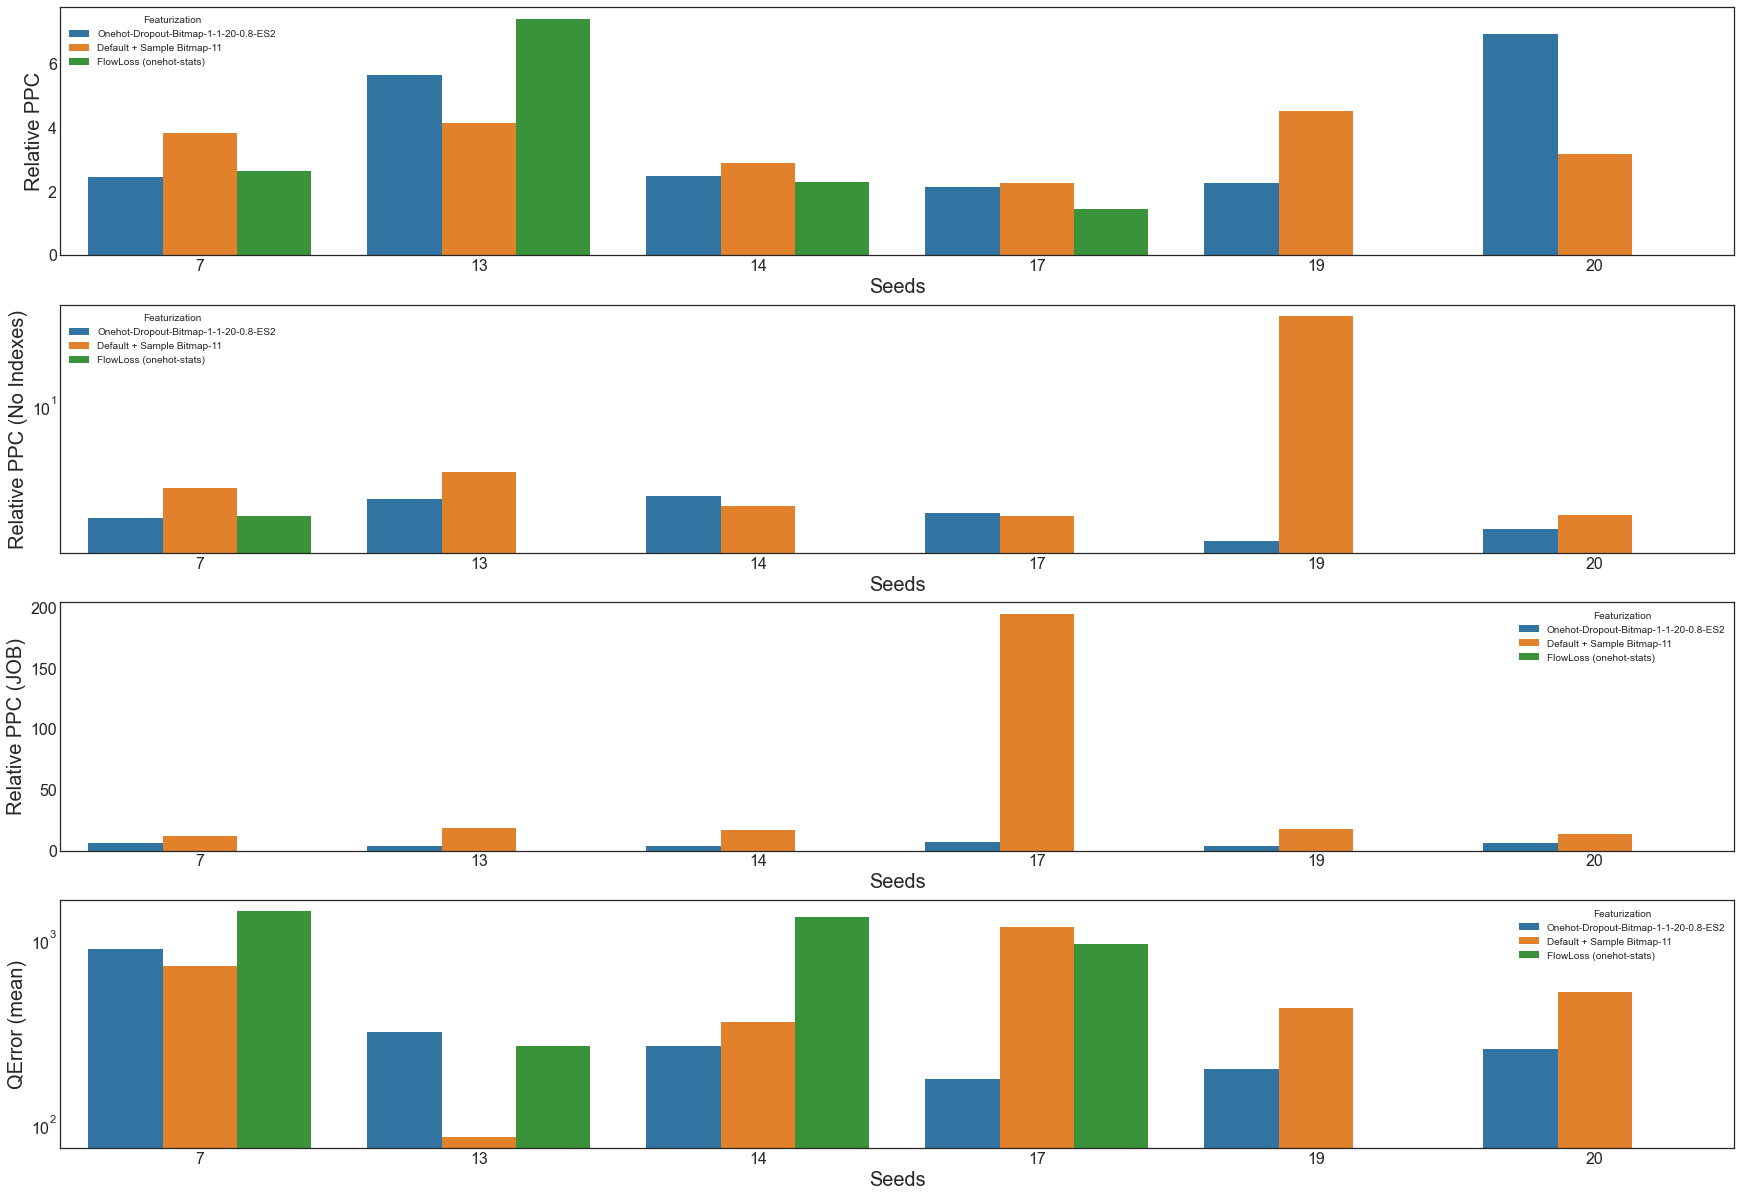

In [548]:
plt.style.use("seaborn-white")
fig, axs = plt.subplots(figsize=(30,21), nrows=4, ncols=1)
ax = axs[0]
sns.barplot(x="diff_templates_seed", y="Final-Relative-TotalPPCost-test", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator)
ax.set_ylabel("Relative PPC", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

# ax = axs[1]
# sns.barplot(x="diff_templates_seed", y="Final-PostgresPlanCost-C-test-mean", hue="Featurization", data=pdf, 
#            ax=ax, ci=ci)
# ax.set_yscale("log")
# ax.set_ylabel("PostgreSQL Cost (mean)", fontsize=20)
# ax.set_xlabel("Seeds", fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

ax = axs[1]
sns.barplot(x="diff_templates_seed", y="Final-Relative-TotalPPCost-test-C2", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator)
ax.set_yscale("log")
ax.set_ylabel("Relative PPC (No Indexes)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

ax = axs[2]
sns.barplot(x="diff_templates_seed", y="Final-Relative-TotalPPCost-job", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator)
ax.set_ylabel("Relative PPC (JOB)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)


ax = axs[3]
sns.barplot(x="diff_templates_seed", y="Final-QError-test-mean", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator)
ax.set_yscale("log")
ax.set_ylabel("QError (mean)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

FN = os.path.join(SAVE_DIR, "AllSeedsSummary-test.pdf")
plt.savefig(FN)

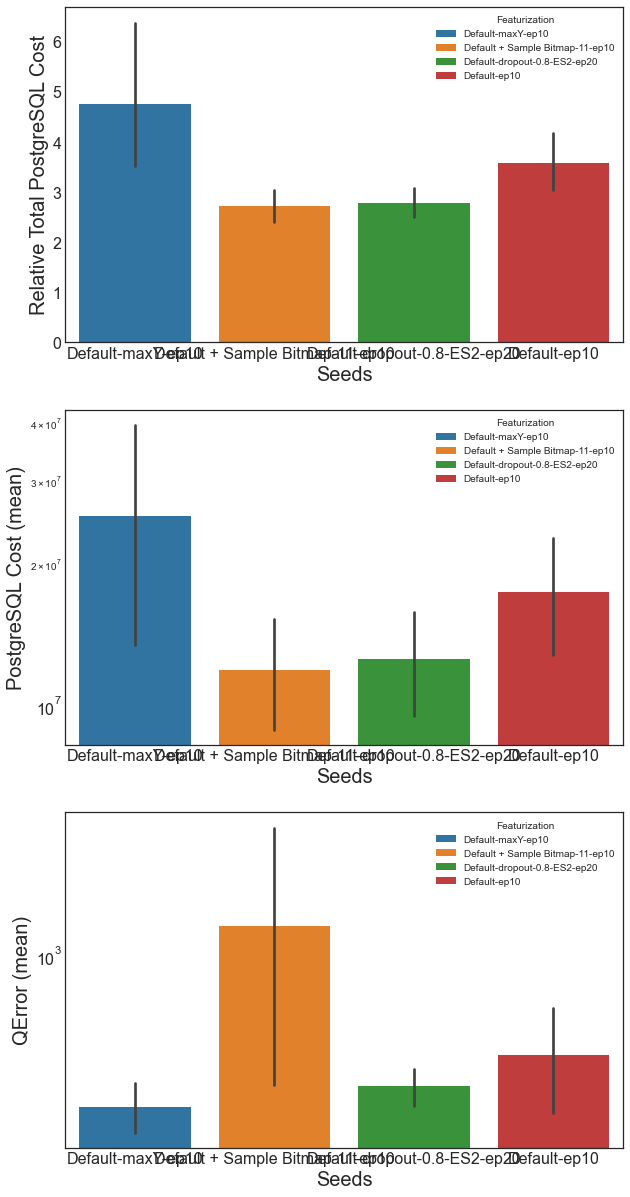

In [476]:
plt.style.use("seaborn-white")
fig, axs = plt.subplots(figsize=(10,21), nrows=3, ncols=1)
ax = axs[0]
sns.barplot(x="Featurization", y="Final-Relative-TotalPPCost-test", hue="Featurization", data=pdf, 
           ax=ax, ci=95, dodge=False)
ax.set_ylabel("Relative Total PostgreSQL Cost", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

ax = axs[1]
sns.barplot(x="Featurization", y="Final-PostgresPlanCost-C-test-mean", hue="Featurization", data=pdf, 
           ax=ax, ci=95, dodge=False)
ax.set_yscale("log")
ax.set_ylabel("PostgreSQL Cost (mean)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

ax = axs[2]
sns.barplot(x="Featurization", y="Final-QError-test-mean", hue="Featurization", data=pdf, 
           ax=ax, ci=95, dodge=False)
ax.set_yscale("log")
ax.set_ylabel("QError (mean)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

# ax = axs[3]
# sns.barplot(x="diff_templates_seed", y="Final-LogicalConstraints-test-mean", hue="Featurization", data=pdf, 
#            ax=ax)
# #ax.set_yscale("log")
# ax.set_ylabel("PrimaryKeyConstraints (mean)", fontsize=20)
# ax.set_xlabel("Seeds", fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

FN = os.path.join(SAVE_DIR, "CombinedSummary-test.pdf")
plt.savefig(FN)

In [422]:
cdf = df[~df["Final-LogicalConstraints-train-mean"].isna()]
print(len(cdf))

KeyError: 'Final-LogicalConstraints-train-mean'

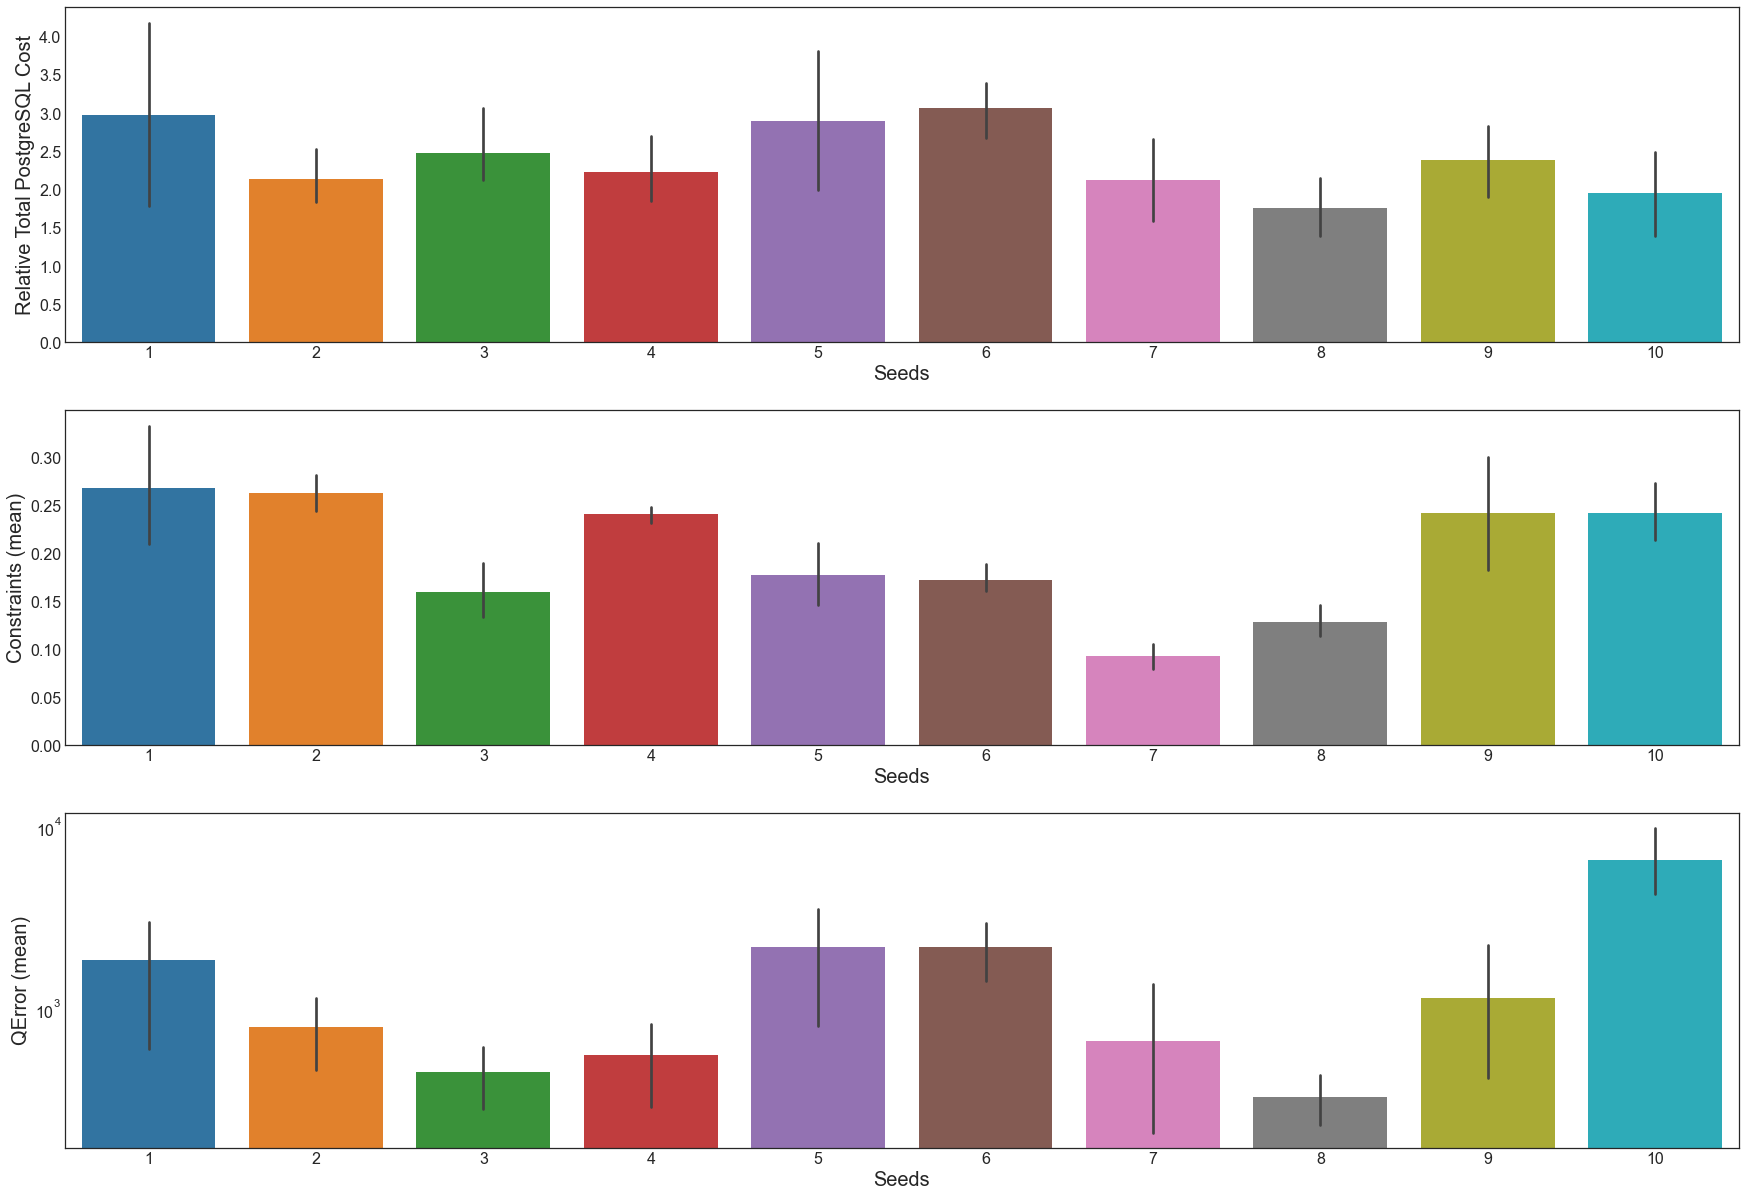

In [229]:
plt.style.use("seaborn-white")
fig, axs = plt.subplots(figsize=(30,21), nrows=3, ncols=1)

HUE=None
ax = axs[0]
sns.barplot(x="diff_templates_seed", y="Final-Relative-TotalPPCost-test", hue=HUE, data=cdf, 
           ax=ax)
ax.set_ylabel("Relative Total PostgreSQL Cost", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

ax = axs[1]
sns.barplot(x="diff_templates_seed", y="Final-LogicalConstraints-test-mean", hue=HUE, data=cdf, 
           ax=ax)
#ax.set_yscale("log")
ax.set_ylabel("Constraints (mean)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

ax = axs[2]
sns.barplot(x="diff_templates_seed", y="Final-QError-test-mean", 
           hue=HUE, 
           data=cdf, 
           ax=ax)
ax.set_yscale("log")
ax.set_ylabel("QError (mean)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

In [299]:
ddf = df[df.Featurization.str.contains("Onehot-dropout")]

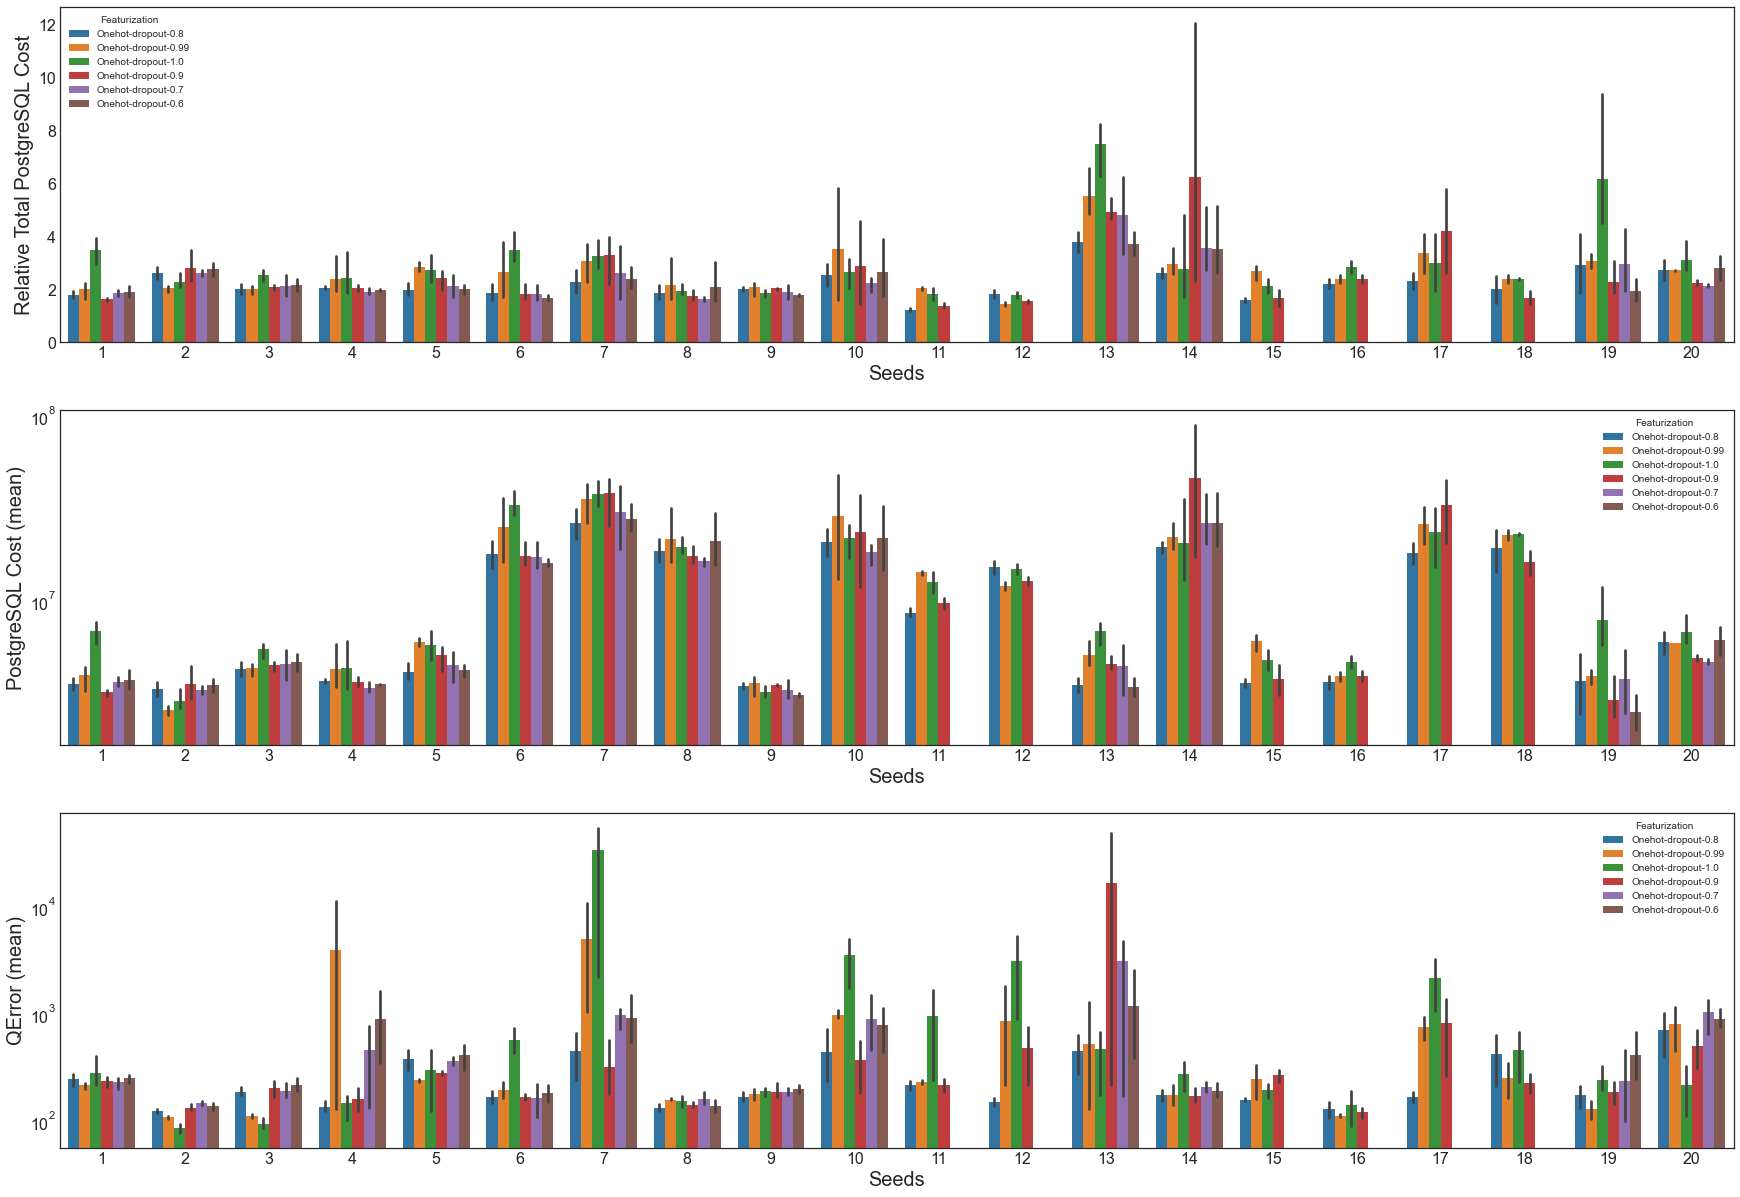

In [300]:
plt.style.use("seaborn-white")
fig, axs = plt.subplots(figsize=(30,21), nrows=3, ncols=1)
ax = axs[0]
sns.barplot(x="diff_templates_seed", y="Final-Relative-TotalPPCost-test", hue="Featurization", data=ddf, 
           ax=ax)
ax.set_ylabel("Relative Total PostgreSQL Cost", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

ax = axs[1]
sns.barplot(x="diff_templates_seed", y="Final-PostgresPlanCost-test-mean", hue="Featurization", data=ddf, 
           ax=ax)
ax.set_yscale("log")
ax.set_ylabel("PostgreSQL Cost (mean)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

ax = axs[2]
sns.barplot(x="diff_templates_seed", y="Final-QError-test-mean", hue="Featurization", data=ddf, 
           ax=ax)
ax.set_yscale("log")
ax.set_ylabel("QError (mean)", fontsize=20)
ax.set_xlabel("Seeds", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

# ax = axs[3]
# sns.barplot(x="diff_templates_seed", y="Final-LogicalConstraints-test-mean", hue="Featurization", data=pdf, 
#            ax=ax)
# #ax.set_yscale("log")
# ax.set_ylabel("PrimaryKeyConstraints (mean)", fontsize=20)
# ax.set_xlabel("Seeds", fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

FN = os.path.join(SAVE_DIR, "AllSeedsSummary-dropout.pdf")
plt.savefig(FN)